C:\Users\e351722\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\e351722\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\e351722\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\e351722\AppData\Local\Continuum\anaconda3\lib\site-packages\ipyk

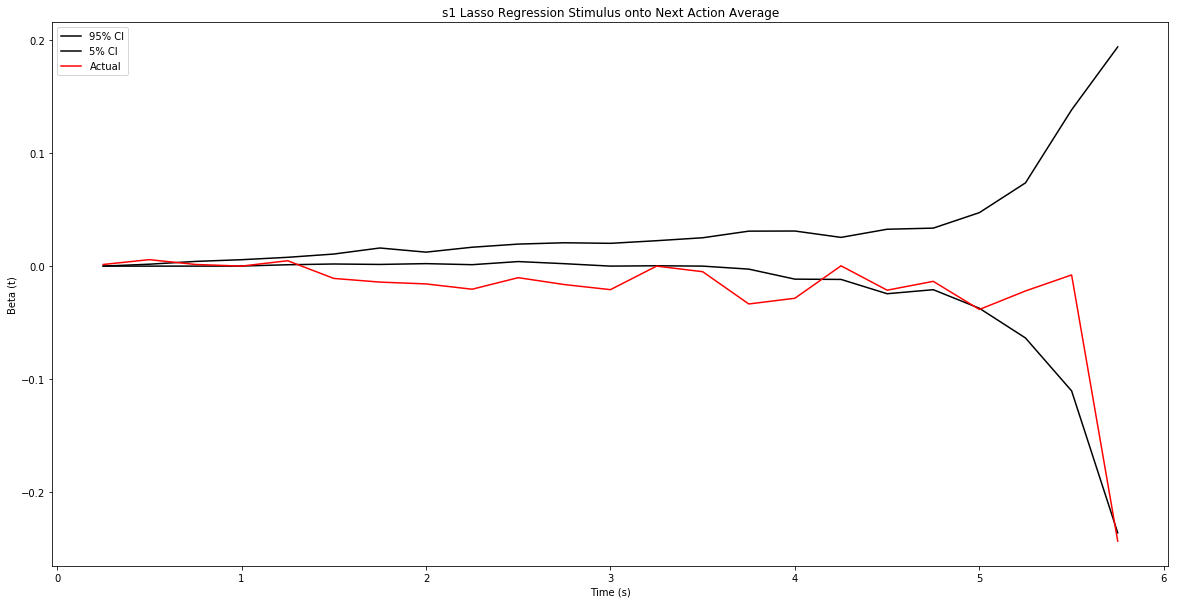

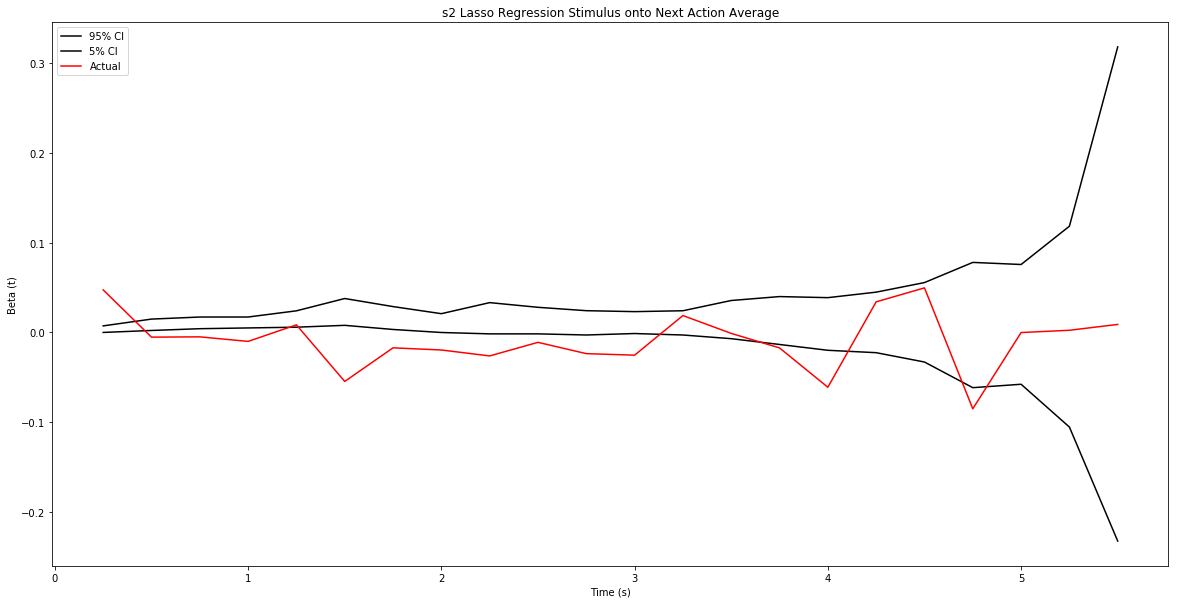

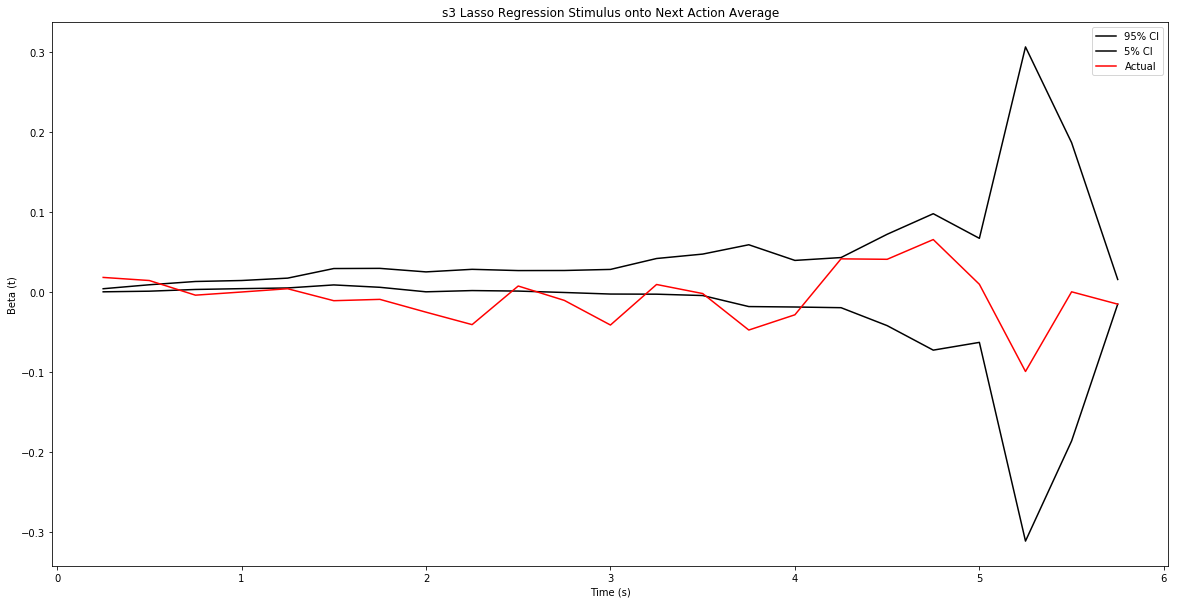

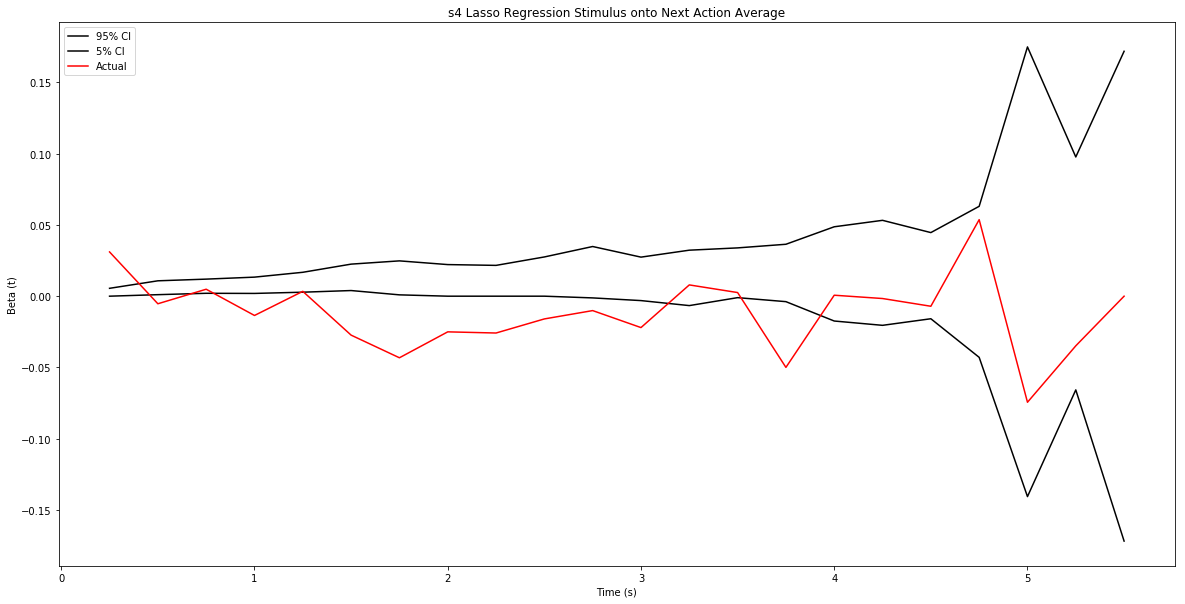

In [3]:
# Experiment 3 Trajectory Analysis

# Import Libraries
import scipy.io
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#Import regression libraries and split data into train-test sets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.model_selection import KFold # you have everything done for you
import random 

subjects = ['s1', 's2', 's3', 's4']
for subject in subjects:
    # Load data for all sessions of one subject
    data = scipy.io.loadmat('C:/Users/e351722/OneDrive - EDP/Thesis/Experiments/experiment_3/x8_'+subject+'_0.mat')


    # get data into a neat dataframe
    names = list(data)
    ntrials = np.size(data[names[21]])
    original_responses = data['responses'][0]
    original_decisionsLed = np.shape(data[names[6]])[0]
    fast_signals = np.shape(data[names[6]])[1]
    time = np.linspace(0.25,7, 28)

    dataframe = pd.DataFrame({'conditions_order': data['conditions_order'][0]})
    vars_extracted = []

    for i in range(3,len(names)):
        if np.shape(data[names[i]]) != (1,):
            if np.shape(data[names[i]])[1] == original_decisionsLed:
                if np.shape(data[names[i]]) == (1,original_decisionsLed):
                    dataframe[names[i]] = data[names[i]][:,data['responses'][0]!=3][0]
                    vars_extracted.append(names[i])

    stimuli = []
    time_stim = []
    for i in range(0,len(dataframe)):
        time_stim.append(time[time<=dataframe.response_times[i]])
        stimuli.append(data['ILD_timecourses'][data['responses'][0]!=3,][i][time<=dataframe.response_times[i]])


    dataframe['ILD_timecourses'] = stimuli
    dataframe['ILD_time'] = time_stim

    # Get faster sampled x-position and timestamps into the dataframe.  
    # We probably want to downsample this.
    for i in [29,47]:
        if np.shape(data[names[i]]) == (original_decisionsLed, fast_signals):
                temp_var = []
                for j in range(0,len(dataframe)):
                    # extract button press data from relevant times only (<RT)
                    # temp_var.append(data[names[i]][j][data['joystick_times'][data['responses'][0]!=3,][j]>0])
                    temp_var.append(data[names[i]][data['responses'][0]!=3,][j][data['joystick_times'][data['responses'][0]!=3,][j]>0])

                dataframe[names[i]] = temp_var 

    dataframe['choice'] = 0
    for i in range(0, len(dataframe)):
        if np.cumsum(dataframe.x_jst_values[i])[len(dataframe.x_jst_values[i])-1] > 0:
            # Right Side
            dataframe['choice'][i] = 2
        elif np.cumsum(dataframe.x_jst_values[i])[len(dataframe.x_jst_values[i])-1] < 0:
            # Left Side
            dataframe['choice'][i]= 1


    # choice = 1, Left
    # choice = 2, Right


    next_move = []
    trial = []
    choice = []
    t_stim = []
    stim = []
    p = []

    dt = 0.5
    for i in range(0,len(dataframe)):
        counter = -1
        for t in time[time<=dataframe.response_times[i]]:      
            counter = counter+1
            next_action = np.nanmean(dataframe['x_jst_values'][i][(dataframe.joystick_times[i]>t)& (dataframe.joystick_times[i]<(t+dt))  ])
            next_move.append(next_action)
            trial.append(i)
            t_stim.append(t)
            choice.append(dataframe.choice[i])
            stim.append(dataframe.ILD_timecourses[i][counter]/6)
            p.append(np.mean(dataframe.ILD_timecourses[i]/6))


    reshaped_data = pd.DataFrame({'trial': trial, 't_stim':t_stim, 'stim':stim, 'next_move':next_move,'choice':choice, 'p':p}).reset_index(drop=True)

    #data_sorted = reshaped_data.sort_values(by=['DATA', 'HORA']).reset_index(drop=True)

    # Regression based Trajectory Analysis

    # 1) Consider only the hard trials, split test/train sets
    hard_trials = reshaped_data[abs(reshaped_data.p)<0.25]

    X_train, X_test, y_train, y_test = train_test_split(
        hard_trials[['stim', 't_stim']], hard_trials.next_move, test_size=0.1, random_state=42)


    # 2) Regress next_move onto stim for each time-step, t_stim.

    betas = []
    ts =  np.sort(list(set(reshaped_data.t_stim)))[:-1]
    alpha = 0.001
    for t in ts:

        # Train Model
        lasso = linear_model.Lasso(alpha = alpha)
        X = pd.DataFrame({'stim':X_train.stim[X_train.t_stim == t]})
        y =  pd.DataFrame({'move':y_train[X_train.t_stim == t]})
        model = lasso.fit(X, y )
        betas.append(model.coef_[0])




    # Generate Confidence Intervals by repeating procedure with suffled stimulus sequences (within trial)

    # Surrogate data: Regress next_move onto stim for each time-step, t_stim.

    nsurrogates = 1000 # number of shuffles
    beta_surrogates = np.ones((nsurrogates, len(betas))) 

    for surrogate in range(0, nsurrogates):
        # surrogate data
        next_move_s = []
        trial_s = []
        choice_s = []
        t_stim_s = []
        stim_s = []
        p_s = []

        for i in range(0,len(dataframe)):
            counter = -1
            counts = list(range(0, len(time[time<=dataframe.response_times[i]])))
            random.shuffle(counts)
            for t in time[time<=dataframe.response_times[i]]:    

                counter = counter+1
                next_action = np.nanmean(dataframe['x_jst_values'][i][(dataframe.joystick_times[i]>t)& (dataframe.joystick_times[i]<(t+dt))  ])
                next_move_s.append(next_action)
                trial_s.append(i)
                t_stim_s.append(t)
                choice_s.append(dataframe.choice[i])
                stim_s.append(dataframe.ILD_timecourses[i][counts[counter]]/6)
                p_s.append(np.mean(dataframe.ILD_timecourses[i]/6))


        reshaped_data_s = pd.DataFrame({'trial': trial_s, 't_stim':t_stim_s, 'stim':stim_s, 'next_move':next_move_s,'choice':choice_s, 'p' : p_s}).reset_index(drop=True)
        hard_trials_s = reshaped_data_s[abs(reshaped_data_s.p)<0.5]

        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
            hard_trials_s[['stim', 't_stim']], hard_trials_s.next_move, test_size=0.1, random_state=42)

        # Regress next_move onto stim for each time-step, t_stim.

        betas_s = []
        ts =  np.sort(list(set(reshaped_data.t_stim)))[:-1]
        for t in ts:

            # Train Model
            lasso_s = linear_model.Lasso(alpha = alpha)
            X_s = pd.DataFrame({'stim':X_train_s.stim[X_train_s.t_stim == t]})
            y_s =  pd.DataFrame({'move':y_train_s[X_train_s.t_stim == t]})
            model_s = lasso.fit(X_s, y_s )
            betas_s.append(model_s.coef_[0])

        beta_surrogates[surrogate,:] = betas_s

    # Plot betas with 95% CI    

    ci_95 = []
    ci_5 = []


    for i in range(0, len(betas)):
        ci_95.append(np.percentile(beta_surrogates[:,i], 95))
        ci_5.append(np.percentile(beta_surrogates[:,i], 5))

    plt.figure(figsize=(20,10))
    plt.plot(ts, ci_95, color = 'Black')
    plt.plot(ts, ci_5, color = 'Black')

    plt.plot(ts, betas, color = 'Red')
    plt.title(subject+' Lasso Regression Stimulus onto Next Action Average')
    plt.xlabel('Time (s)')
    plt.ylabel('Beta (t)')
    plt.legend([ '95% CI', '5% CI', 'Actual'])

